In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os

from mlptools.io.read import read_from_dp_data
from mlptools.utils.constants import ZERO_POINT_ENERGY

path2data = '/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data'
path2train = os.path.join(path2data, 'train')
path2test = os.path.join(path2data, 'test')

## List of analysis

- number of data of each mpid
- number of atom of each structure
- energy, force distribution
- RDF
- energy dependence of dimer data

In [4]:
def get_dp_data_info_from_npy(path2data):
    info_list = []
    path2allmpdata = glob(f'{path2data}/mp-*')
    for path2mpdata in path2allmpdata:
        path2system = os.path.join(path2mpdata, 'set.000')
        print(path2system)
        npy_files = glob(f'{path2system}/*.npy')

        num_data = {np.load(f).shape[0] for f in npy_files}
        if len(num_data) != 1:
            raise Exception('not consistent')
        info_list.append([path2mpdata.split('/')[-1], num_data.pop()])
    return info_list

train_info = get_dp_data_info_from_npy(path2train)
test_info = get_dp_data_info_from_npy(path2test)

/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-92_32/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-1079649_16/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-slab_56/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-four_4/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-165_32/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-149_64/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-149_8/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-three_3/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-149_dimer_2/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/train/mp-571520_24/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/test/mp-92_32/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/test/mp-1079649_16/set.000
/Users/y1u0d2/desktop/Lab/result/deepmd/Si/32/data/test/mp-slab_56/set.000
/Users/y1u0d

In [5]:
all_info = []
for (mp_train, train_size), (mp_test, test_size) in zip(train_info, test_info):
    if mp_train != mp_test:
        print(mp_train, mp_test)
        continue
    all_info.append([mp_train, train_size, test_size])

dp_data_info_df = pd.DataFrame(data=all_info, columns=['mpid', 'train_size', 'test_size'])
dp_data_info_df['total'] = dp_data_info_df['train_size'] + dp_data_info_df['test_size']

In [6]:
print(f"Data size of train: {np.sum(dp_data_info_df['train_size'].values)}")
print(f"Data size of test: {np.sum(dp_data_info_df['test_size'].values)}")
print(f"Total: {np.sum(dp_data_info_df['train_size'].values) + np.sum(dp_data_info_df['test_size'].values)}")
dp_data_info_df

Data size of train: 45477
Data size of test: 5058
Total: 50535


,mpid,train_size,test_size,total
0,mp-92_32,4393,489,4882
1,mp-1079649_16,3253,362,3615
2,mp-slab_56,139,16,155
3,mp-four_4,48,6,54
4,mp-165_32,2736,305,3041
5,mp-149_64,1777,198,1975
6,mp-149_8,30243,3361,33604
7,mp-three_3,90,10,100
8,mp-149_dimer_2,62,7,69
9,mp-571520_24,2736,304,3040


In [7]:
def get_all_atoms(path2target):
    all_atoms = []
    path2allmpdata = glob(f'{path2target}/mp-*')
    for path2mpdata in path2allmpdata:
        path2system = os.path.join(path2mpdata, 'set.000')
        all_atoms += read_from_dp_data(path2system)
    return all_atoms

In [8]:
all_atoms_train = get_all_atoms(path2train)
all_atoms_test = get_all_atoms(path2test)

In [9]:
len(all_atoms_train), len(all_atoms_test)

(45477, 5058)

In [10]:
# plot energy distribution
all_atoms = all_atoms_train + all_atoms_test
all_dimers = []
all_slabs = []

energy_arr = []
for atoms in all_atoms:
    if atoms.structure_id == 'mp-slab':
        all_slabs.append(atoms)
    elif atoms.structure_id == 'mp-149_dimer':
        all_dimers.append(atoms)
    elif atoms.structure_id in ['mp-three', 'mp-four']:
        continue
    else:
        energy_arr.append([atoms.structure_id, atoms.n_atoms, atoms.get_volume(), atoms.get_atomic_volume(), atoms.energy, atoms.get_atomic_energy()])
energy_df = pd.DataFrame(data=energy_arr, columns=['structure_id', 'n_atoms', 'volume', 'atomic_volume', 'energy', 'atomic_energy'])

<AxesSubplot: xlabel='volume per atom (ang^3)', ylabel='energy per atom (eV)'>

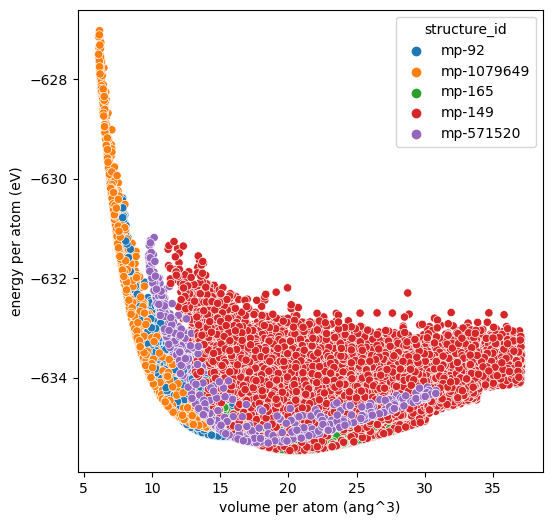

In [11]:
import seaborn as sns

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_xlabel('volume per atom (ang^3)')
ax.set_ylabel('energy per atom (eV)')

sns.scatterplot(data=energy_df, x='atomic_volume', y='atomic_energy', hue='structure_id', ax=ax)

Text(0, 0.5, 'energy (eV)')

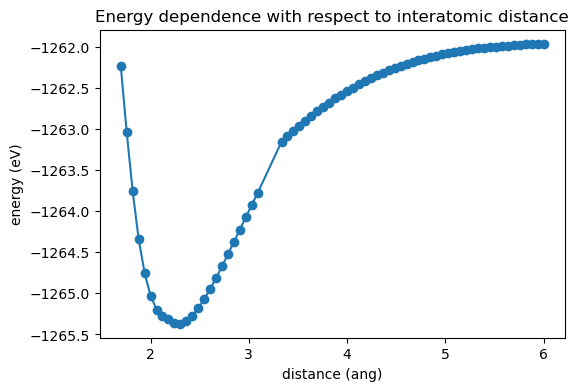

In [12]:
energy_arr = [[atoms.get_atomic_distance(), atoms.energy] for atoms in all_dimers]
energy_df = pd.DataFrame(data=np.array(energy_arr), columns=['distance', 'energy'])
energy_df = energy_df.sort_values(by='distance').reset_index(drop=True)

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(energy_df['distance'], energy_df['energy'], marker='o')
ax.set_title('Energy dependence with respect to interatomic distance')
ax.set_xlabel('distance (ang)')
ax.set_ylabel('energy (eV)')

Text(0, 0.5, 'energy (eV)')

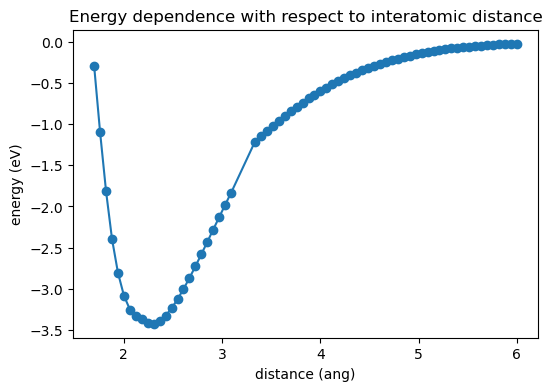

In [13]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(energy_df['distance'], energy_df['energy']-2*ZERO_POINT_ENERGY, marker='o')
ax.set_title('Energy dependence with respect to interatomic distance')
ax.set_xlabel('distance (ang)')
ax.set_ylabel('energy (eV)')

In [14]:
# plot force distribution
force_arr = []
for atoms in all_atoms:
    force_arr.append(np.hstack([atoms.force, np.full([atoms.n_atoms, 1], atoms.structure_id)]))
force_arr = np.vstack(force_arr)
idx = np.random.randint(len(force_arr), size=int(len(force_arr)*0.01))

force_df = pd.DataFrame(data=force_arr[idx, :], columns=['fx', 'fy', 'fz', 'structure_id']).astype(
            {
                'fx': 'float16',
                'fy': 'float16',
                'fz': 'float16'
            })

<AxesSubplot: xlabel='fx', ylabel='fz'>

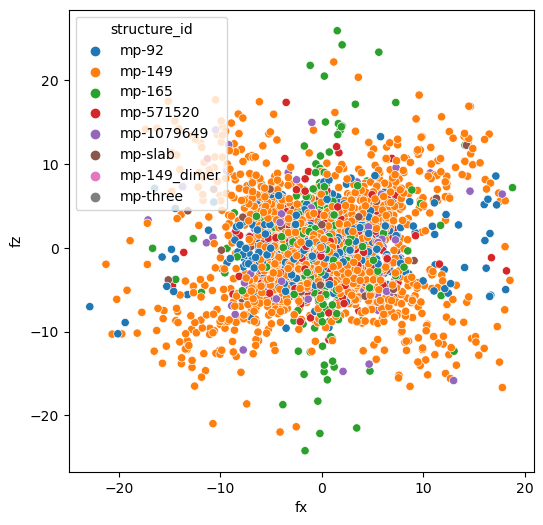

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

sns.scatterplot(data=force_df, x='fx', y='fz', hue='structure_id', ax=ax)

In [16]:
force_arr = []
for dimer in all_dimers:
    distance = np.linalg.norm(dimer.coord[0]-dimer.coord[1])
    force_arr.append([distance, dimer.force[0][0]])
force_df = pd.DataFrame(data=np.array(force_arr), columns=['distance', 'force'])
force_df = force_df.sort_values(by='distance').reset_index(drop=True)

Text(0, 0.5, 'force (eV/ang)')

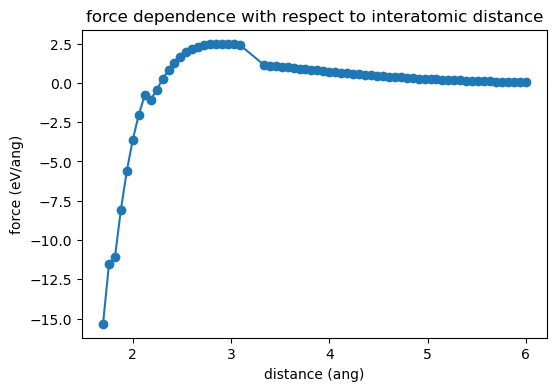

In [17]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

ax.plot(force_df['distance'], force_df['force'], marker='o')
ax.set_title('force dependence with respect to interatomic distance')
ax.set_xlabel('distance (ang)')
ax.set_ylabel('force (eV/ang)')

In [18]:
# RDF
import random

In [19]:
rcut = 5
bins = 100
n_sample = 1000

In [20]:
blacklist = ['mp-three', 'mp-four']
all_atoms = [atoms for atoms in all_atoms if atoms.structure_id not in blacklist]

In [21]:
distance = all_atoms[0].get_rdf(rcut, bins)[:, 0]
rdf_val = np.array([atoms.get_rdf(rcut, bins)[:, 1] for atoms in random.sample(all_atoms, n_sample)])

1   HIToolbox                           0x00007ff8166e4726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8166e42b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff816688908 SetMenuBarObscured + 408
4   HIToolbox                           0x00007ff8166884ca _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 164
5   HIToolbox                           0x00007ff816682996 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 252
6   HIToolbox                           0x00007ff81664abd2 _NotifyEventLoopObservers + 153
7   HIToolbox                           0x00007ff8166823e6 AcquireEventFromQueue + 494
8   HIToolbox                           0x00007ff8166713ec ReceiveNextEventCommon + 285
9   HIToolbox                           0x00007ff8166712b3 _BlockUntilNextEventMatchingListInModeWithFilter + 70
10  AppKit                              0x00007ff80fe78f33 _DPS

(0.0, 5.630973556348741)

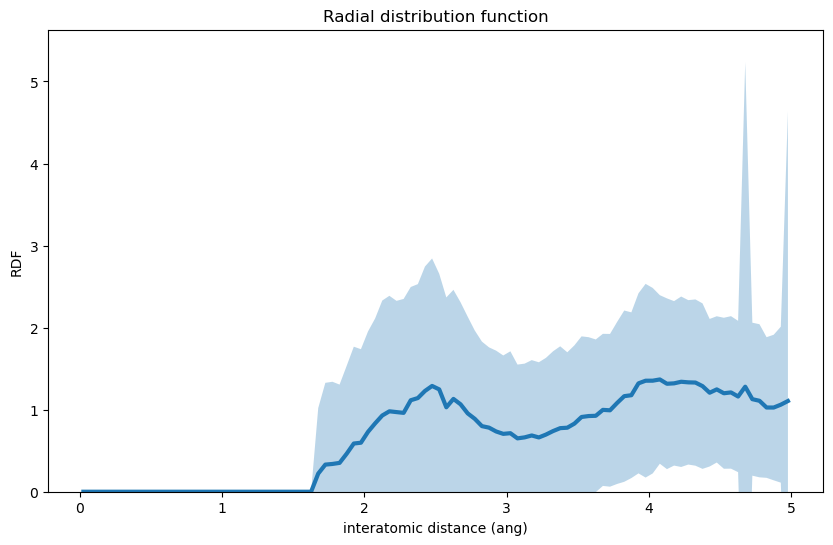

In [22]:
rdf_mean = np.mean(rdf_val, axis=0)
rdf_std = np.std(rdf_val, axis=0)

fig = plt.figure(figsize=(10,6))
# plt.rcParams['font.size'] = '16'
ax = fig.add_subplot(111)
ax.set_title('Radial distribution function')
ax.set_xlabel('interatomic distance (ang)')
ax.set_ylabel('RDF')

ax.plot(distance, rdf_mean, lw=3)
ax.fill_between(distance, rdf_mean+rdf_std, rdf_mean-rdf_std, alpha=0.3)
ax.set_ylim(0, )